In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, LinearRegression
import statsmodels.api as sm
from BayesianLasso import BayesianLasso

In [2]:
# Load Dataset

filename = "Data/training_data_Correlated70x6.pickle"

with open(filename,"rb") as file:
    X_train, y_train = pickle.load(file)
    
X_train.shape, y_train.shape

((70, 6), (70, 1))

In [3]:
# True Beta and Relationships in the dataset
# true Beta = [0.8,-1.5,0.1,0,...,0]
# X3 = 4X1-2X2 + eps
# X5 = 3X3 - 6X4 + eps
# X6 indep.

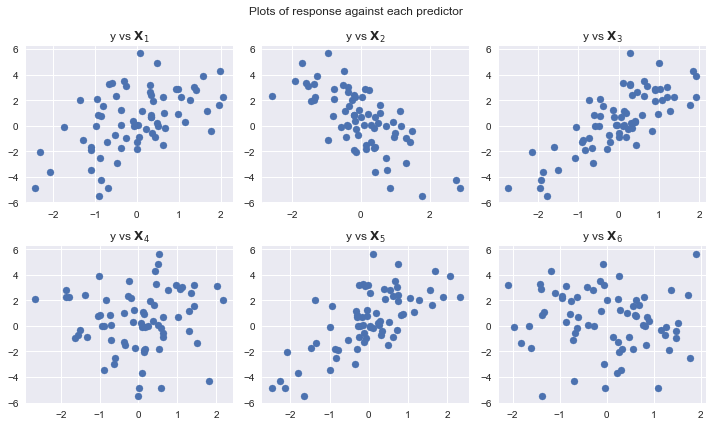

In [4]:
# Standardise X and make plots
plt.style.use("seaborn")
X_trainStd = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)

# First make some plots
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
for row in range(1,3):
    for column in range(1,4):
        ax[row-1][column-1].scatter(X_trainStd[:,3*(row-1)+column-1],y_train)
        ax[row-1][column-1].title.set_text(fr"y vs $\mathbf{{X}}_{{{3*(row-1)+column}}}$")
        
# Looks like potential linear correlations with beta1, beta2, beta 3 from the plot.

plt.suptitle("Plots of response against each predictor")
plt.tight_layout()
plt.show()

In [5]:
# Secondly, I find the OLS estimates using both scikit and statsmodels
# SciKit
skmodel = LinearRegression(fit_intercept=False)
skmodel.fit(X_trainStd,y_train-np.mean(y_train))
print(skmodel.coef_)
# StatsModels
smModel = sm.OLS(y_train-np.mean(y_train),X_trainStd).fit()
smModel.summary()

[[ 0.4109308  -1.2987154   2.24581716 -0.1415402  -1.39071956  0.03596161]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.814
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              46.59
Date:                Thu, 02 Sep 2021   Prob (F-statistic):                    1.67e-21
Time:                        03:49:31   Log-Likelihood:                         -100.63
No. Observations:                  70   AIC:                                      213.3
Df Residuals:                      64   BIC:                                      226.8
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4109      0.629      0.653      0.516      -0.846       1.667
x2            -1.2987      0.323     -4.024      0.000      -1.943      -0.654
x3             2.2458      2.132      1.053      0.296      -2.014       6.506
x4            -0.1415      0.730     -0.194      0.847      -1.601       1.318
x5            -1.3907      2.186     -0.636      0.527      -5.758       2.976
x6             0.0360      0.137      0.263      0.793      -0.237       0.309
==============================================================================
Omnibus:                        3.917   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                3.216
Skew:                           0.349   Prob(JB):                        0.200
Kurtosis:                       3.785   Cond. No.                         41.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# (1) Correlation matrix.
import pandas as pd
corrmatrix = pd.DataFrame(np.corrcoef(X_trainStd,rowvar=False),columns=[i for i in range(1,X_train.shape[1]+1)])
corrmatrix.index = [i for i in range(1,X_train.shape[1]+1)]
corrmatrix.style.set_caption("Correlation Matrix")
# Strong correlations between 1&3, 1& 5, 3&5

,1,2,3,4,5,6
1,1.000000,0.007753,0.884545,-0.025711,0.827195,-0.052005
2,0.007753,1.000000,-0.421247,0.076747,-0.406648,0.045722
3,0.884545,-0.421247,1.000000,-0.062971,0.942420,-0.087908
4,-0.025711,0.076747,-0.062971,1.000000,-0.387871,-0.310442
5,0.827195,-0.406648,0.942420,-0.387871,1.000000,0.027027
6,-0.052005,0.045722,-0.087908,-0.310442,0.027027,1.000000


In [7]:
# (2) Variance Inflation Factors
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifs = pd.DataFrame()
vifs["Predictor"] = [i for i in range(1,X_train.shape[1]+1)]
vifs["VIF"] = [variance_inflation_factor(X_trainStd,i) for i in range(0,X_train.shape[1])]
vifs
# For the predictors 1,2,3,4,5, the VIF is large, implying that the R^2s in the partial regressions are close to one
# In this case, the residual sum of squares in the partial regressions is close to zero, implying a good fit
# i.e. the predictor is linearly related to other predictors
# The other 2 elso exhibit multicollinearity
# (Montgomery, 2001) says VIF greater than 5 suggests multicollinearity

,Predictor,VIF
0,1,24.390659
1,2,6.421053
2,3,280.320727
3,4,32.893411
4,5,294.620549
5,6,1.150168


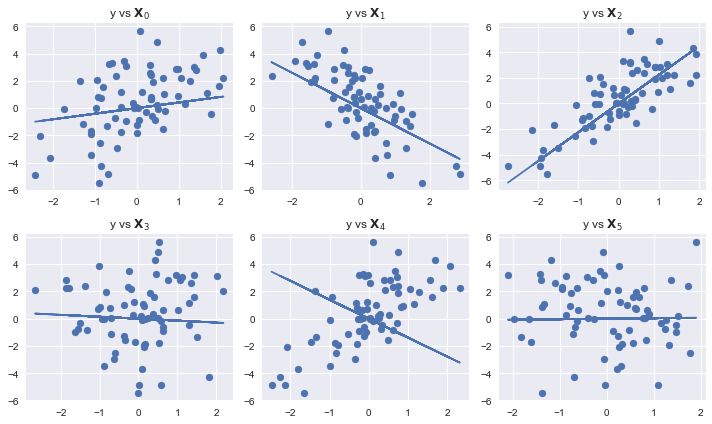

In [8]:
# Plot line of best fit
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
for row in range(1,3):
    for col in range(1,4):
        ax[row-1][col-1].scatter(X_trainStd[:,3*(row-1)+col-1],y_train)
        ax[row-1][col-1].plot(X_trainStd[:,3*(row-1)+col-1],X_trainStd[:,3*(row-1)+col-1]*smModel.params[3*(row-1)+col-1])
        ax[row-1][col-1].title.set_text(fr"y vs $\mathbf{{X}}_{{{3*(row-1)+col-1}}}$")
        
plt.tight_layout()
plt.show()

# Might not affect predictions but doesn't capture the relationship between variables. Use the Lasso

In [9]:
# Bayesian Lasso
lam = 7
bayesianLasso = BayesianLasso(X_trainStd,y_train)
beta_samplesLam, sig2_samplesLam, tau2_samplesLam = bayesianLasso.gibbs_fixedLam(lam,30000)

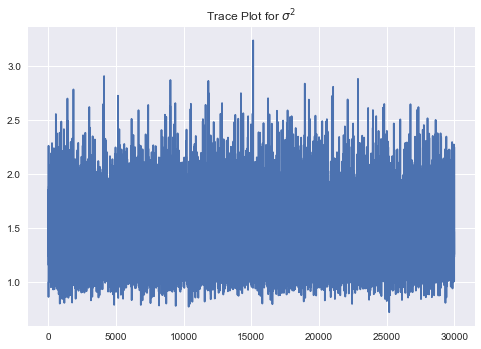

In [10]:
# Trace plot for Sigma^2
plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2_samplesLam)
plt.show()
# A burn in period of 1000 seems sufficient

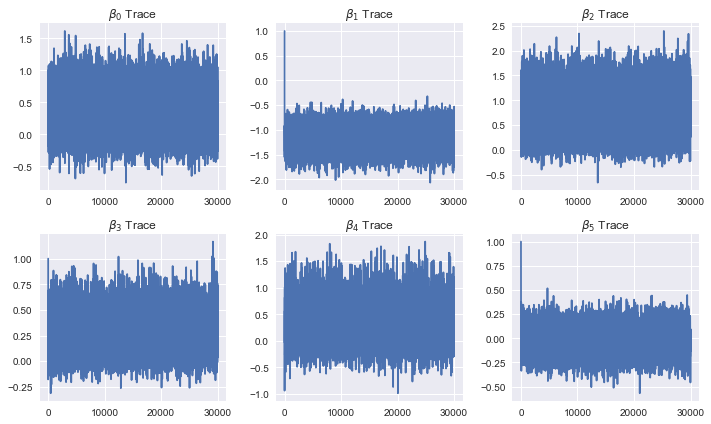

In [11]:
# Trace Plots for the Beta
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(10,6))

for i in range(1,3):
    for j in range(1,4):
        ax[i-1][j-1].plot(beta_samplesLam[:,3*(i-1)+j-1])
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j-1}}}$ Trace")

plt.tight_layout()
plt.show()
# Again a burn in of 2000 seems good

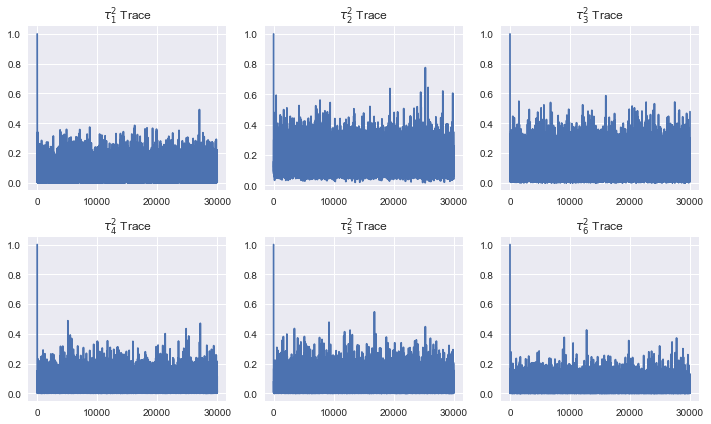

In [12]:
# Trace Plots for the Tau^2
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(10,6))

for i in range(1,3):
    for j in range(1,4):
        ax[i-1][j-1].plot(tau2_samplesLam[:,3*(i-1)+j-1])
        ax[i-1][j-1].title.set_text(fr"$\tau_{{{3*(i-1)+j}}}^{2}$ Trace")

plt.tight_layout()
plt.show()
# Again a burn in of 2000 seems good - plotted on a log scale since there were large tau2 sqiuggles but I wasn't sure 
# whether that was lack of convergence or not

In [13]:
burned_beta_tracesLam = beta_samplesLam[10000:,:]
burned_sig2_tracesLam = sig2_samplesLam[10000:]
burned_tau2_tracesLam = tau2_samplesLam[10000:,:]

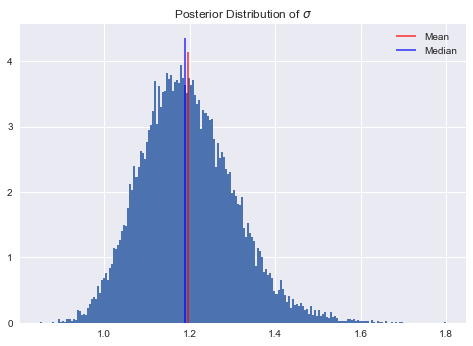

Mean: 1.196014527798879
Median: 1.188234001431829


In [14]:
# Histogram for Sigma^2

plt.title(r"Posterior Distribution of $\sigma$")
plt.hist(np.sqrt(burned_sig2_tracesLam),bins=200,density=True)
plt.vlines(np.mean(np.sqrt(burned_sig2_tracesLam)),0,plt.gca().get_ylim()[1],colors="r",label="Mean",alpha=0.7)
plt.vlines(np.median(np.sqrt(burned_sig2_tracesLam)),0,plt.gca().get_ylim()[1],colors="b",label="Median",alpha=0.7)
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(np.sqrt(burned_sig2_tracesLam))}")
print(f"Median: {np.median(np.sqrt(burned_sig2_tracesLam))}")

In [15]:
# I now calculate the frequentist Lasso estimates that SHOULD (theoretically) equal the mode of the posterior distribution
# I check this using scikit and statsmodels

sigmamedian = np.median(np.sqrt(burned_sig2_tracesLam))

# Check with SciKit's Lasso 
skmodel = Lasso(alpha=2*sigmamedian*lam/(2*len(y_train)),fit_intercept=False,tol=1e-12)
skmodel = skmodel.fit(X_trainStd,y_train-np.mean(y_train))
print(skmodel.coef_)

# StatsModel's Lasso
smLasso = sm.OLS(y_train-np.mean(y_train),X_trainStd).fit_regularized(alpha=2*sigmamedian*lam/(2*len(y_train)))
print(smLasso.params)

# Small alpha issue

[ 0.         -1.02786995  1.31087143  0.1776663   0.         -0.        ]
[ 0.         -1.02786995  1.31087143  0.1776663   0.          0.        ]


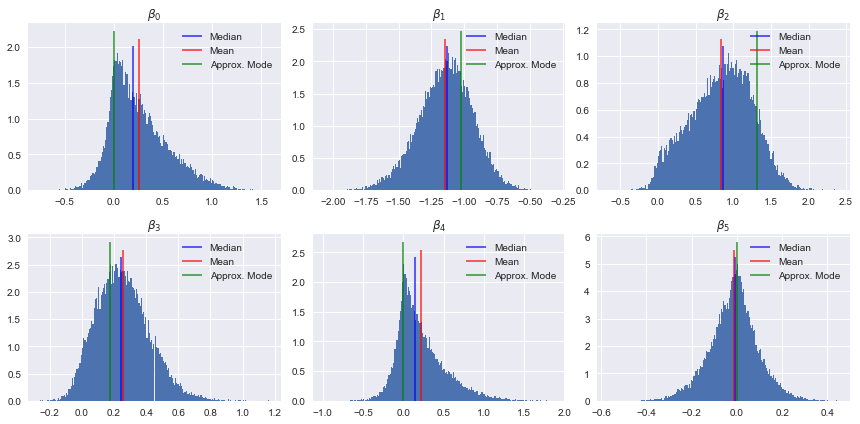

In [16]:
# Histograms for Beta, with medians, means plotted 
# Also plotted the frequentist Lasso estimates that theoretically should be the mode of the posteriors
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(12,6))

for i in range(1, 3):
    for j in range(1,4):
        ax[i-1][j-1].hist(burned_beta_tracesLam[:,3*(i-1) + j-1],bins=200,density=True)
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1) + j-1}}}$")
        ax[i-1][j-1].vlines(np.median(burned_beta_tracesLam,axis=0)[3*(i-1) + j-1],0,ax[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.7)
        ax[i-1][j-1].vlines(np.mean(burned_beta_tracesLam,axis=0)[3*(i-1) + j-1],0,ax[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.7)
        ax[i-1][j-1].vlines(skmodel.coef_[3*(i-1) + j-1],0,ax[i-1][j-1].get_ylim()[1],colors="g",label="Approx. Mode",alpha=0.7)
        ax[i-1][j-1].set_ylim()
        ax[i-1][j-1].legend(loc="upper right")
        
plt.tight_layout()
plt.show()

# The symmetric distributions mean that the mode, mean and medians are really close
# But it does look like the frequentist estimates match the empirical mode of the posteriors.

In [17]:
"""Find maximum marginal likelihood estimate for lambda"""

lambdasMML,lambdaMML = bayesianLasso.lambda_MML(gibbs_iter=7500,em_iter=20)

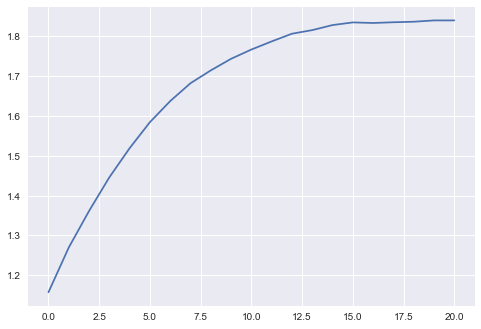

In [18]:
plt.plot(lambdasMML)

In [19]:
lambdaMML

1.8401200647400051

In [20]:
# Run the Gibbs Sampler using this marginal maximum likelihood estimate
betatracesMML,sig2tracesMML,tau2tracesMML = bayesianLasso.gibbs_fixedLam(lambdaMML,30000)

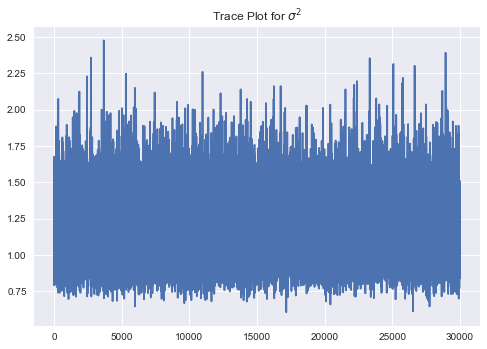

In [21]:
# Trace plot for Sigma^2
plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2tracesMML)
plt.show()
# A burn in period of 1000 seems sufficient

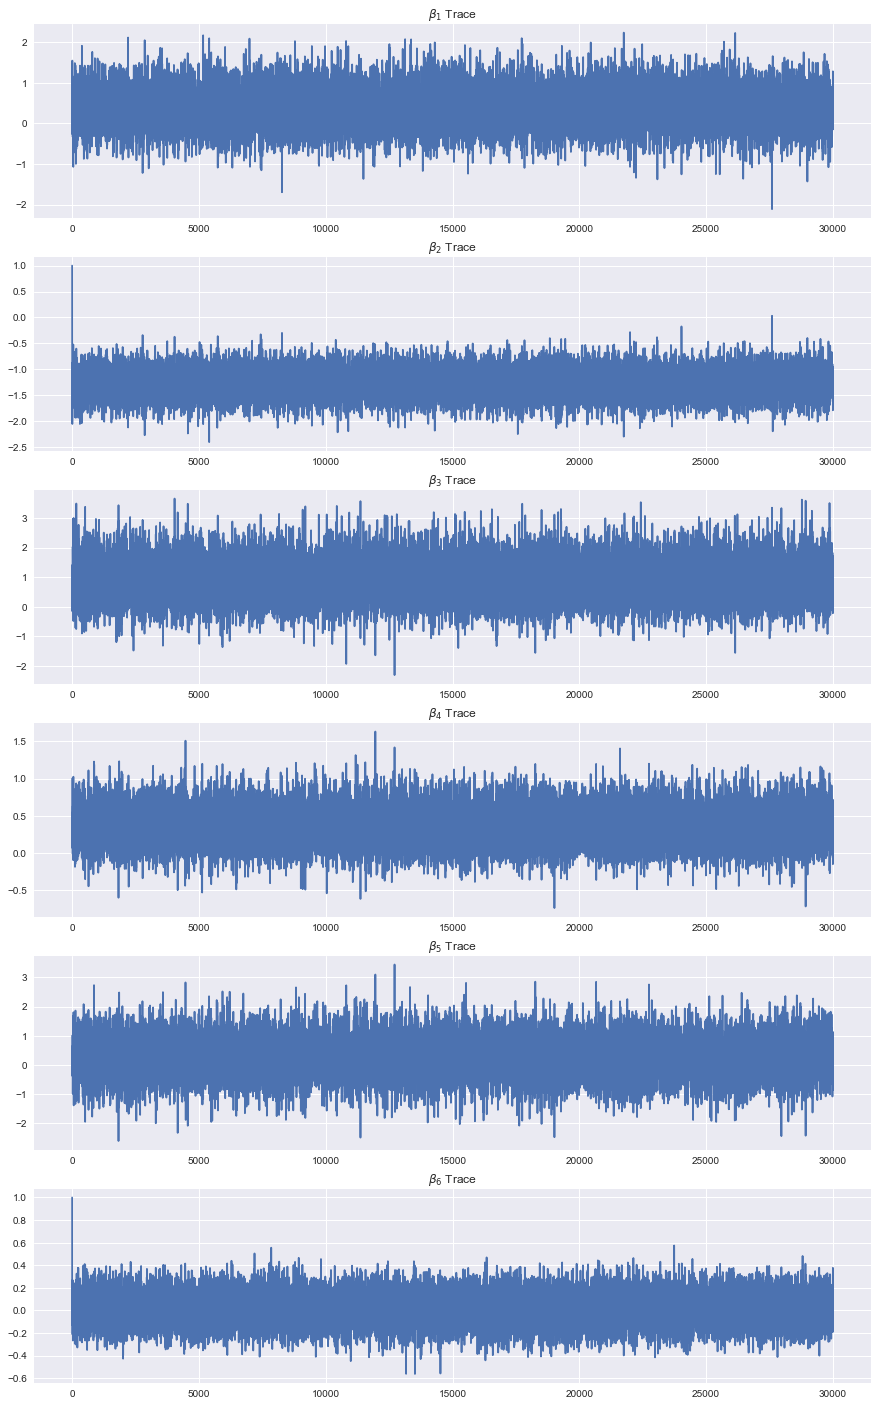

In [22]:
# Trace Plots for the Beta
fig, ax = plt.subplots(betatracesMML.shape[1],figsize=(15,25))

for j in range(1,betatracesMML.shape[1]+1):
    ax[j-1].plot(betatracesMML[:,j-1])
    ax[j-1].title.set_text(fr"$\beta_{{{j}}}$ Trace")

# Again a burn in of 2000 seems good

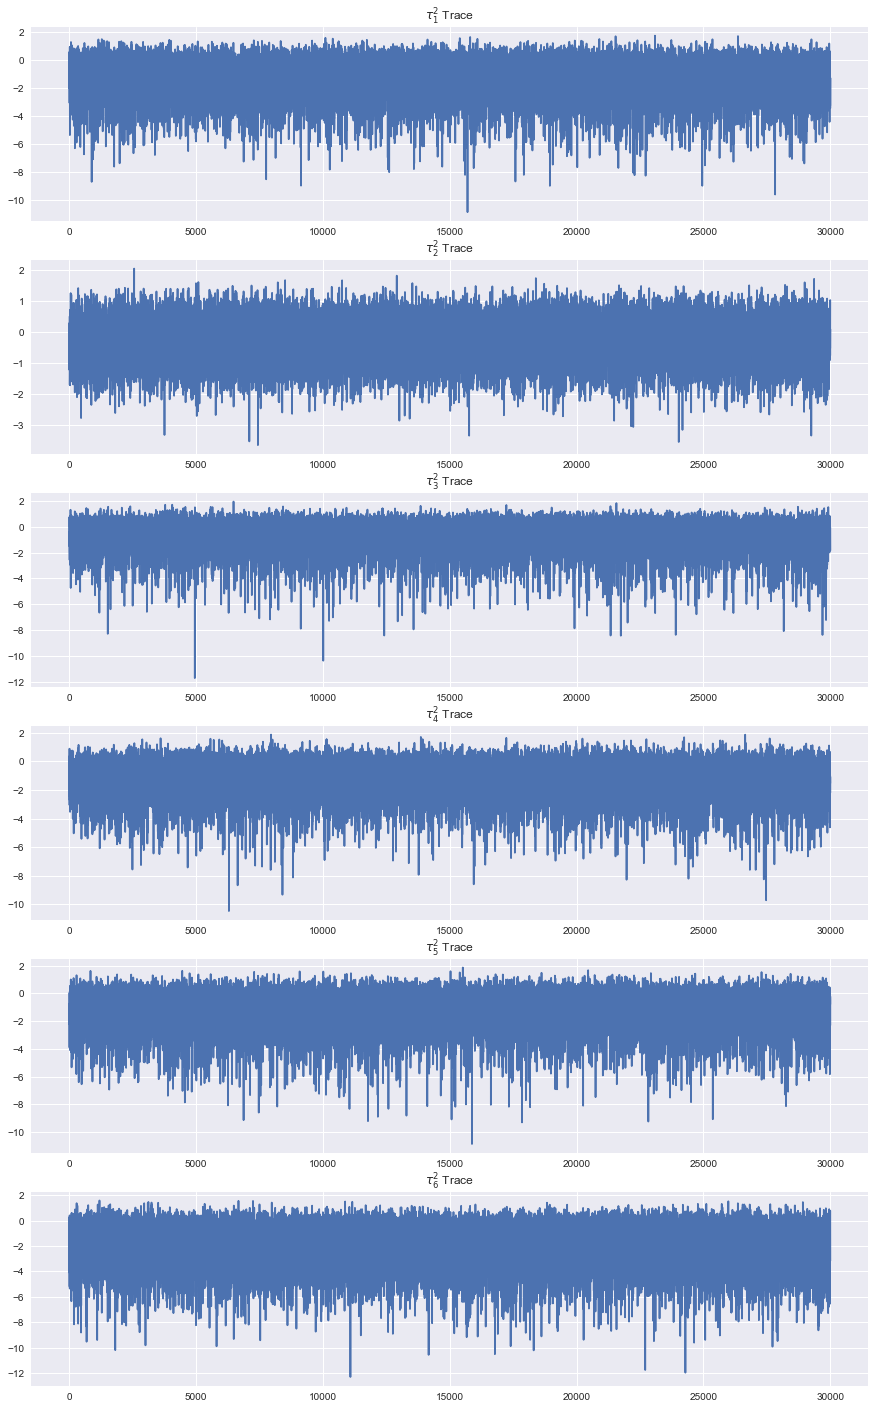

In [23]:
# Trace Plots for the Tau^2
fig, ax = plt.subplots(tau2tracesMML.shape[1],figsize=(15,25))

for j in range(1,tau2tracesMML.shape[1]+1):
    ax[j-1].plot(np.log(tau2tracesMML[:,j-1]))
    ax[j-1].title.set_text(fr"$\tau_{{{j}}}^{2}$ Trace")

# Again a burn in of 2000 seems good - plotted on a log scale since there were large tau2 sqiuggles but I wasn't sure 
# whether that was lack of convergence or not

In [24]:
burnedbetatracesMML, burnedsig2tracesMML, burnedtau2tracesMML = betatracesMML[5000:,:], sig2tracesMML[5000:], tau2tracesMML[5000:,:]

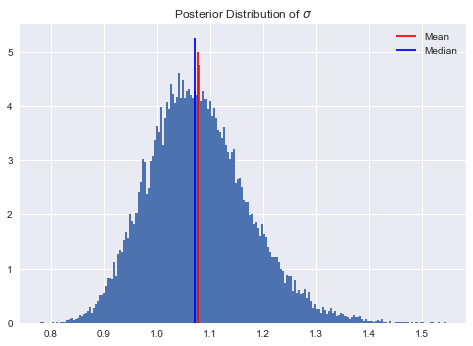

Mean: 1.0784329460696676
Median: 1.0722147887307854


In [25]:
# Histogram for Sigma^2

plt.title(r"Posterior Distribution of $\sigma$")
plt.hist(np.sqrt(burnedsig2tracesMML),bins=200,density=True)
plt.vlines(np.mean(np.sqrt(burnedsig2tracesMML)),0,plt.gca().get_ylim()[1],colors="r",label="Mean")
plt.vlines(np.median(np.sqrt(burnedsig2tracesMML)),0,plt.gca().get_ylim()[1],colors="b",label="Median")
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(np.sqrt(burnedsig2tracesMML))}")
print(f"Median: {np.median(np.sqrt(burnedsig2tracesMML))}")

In [26]:
# I now calculate the frequentist Lasso estimates that SHOULD (theoretically) equal the mode of the posterior distribution
# I check this using scikit and statsmodels

sigmamedian = np.median(np.sqrt(burnedsig2tracesMML))

# Check with SciKit's Lasso 
skMML = Lasso(alpha=2*sigmamedian*lambdaMML/(2*len(y_train)),fit_intercept=False,tol=1e-12)
skMML = skMML.fit(X_trainStd,y_train-np.mean(y_train))
print(skMML.coef_)

# StatsModel's Lasso
smMML = sm.OLS(y_train-np.mean(y_train),X_trainStd).fit_regularized(alpha=2*sigmamedian*lambdaMML/(2*len(y_train)))
print(smMML.params)

[ 0.16792184 -1.17534476  1.19709224  0.27677487  0.          0.        ]
[ 0.35992875 -1.26784443  0.98821539  0.27565752  0.          0.        ]


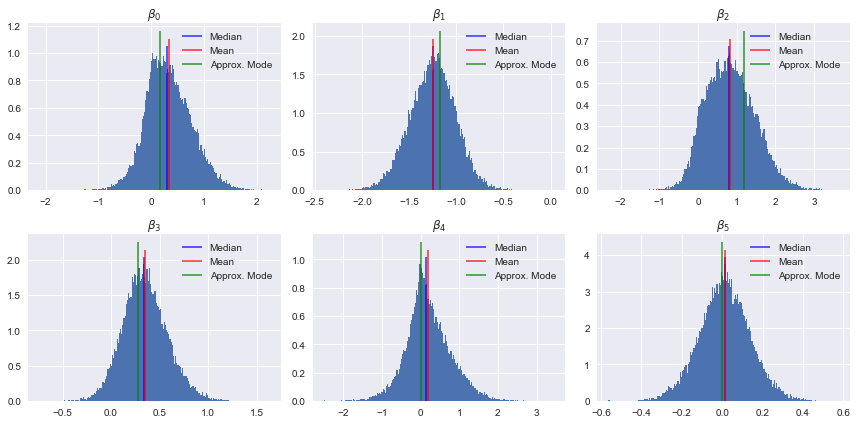

In [27]:
# Histograms for Beta, with medians, means plotted 
# Also plotted the frequentist Lasso estimates that theoretically should be the mode of the posteriors
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(12,6))

for i in range(1, 3):
    for j in range(1,4):
        ax[i-1][j-1].hist(burnedbetatracesMML[:,3*(i-1) + j-1],bins=200,density=True)
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1) + j-1}}}$")
        ax[i-1][j-1].vlines(np.median(burnedbetatracesMML,axis=0)[3*(i-1) + j-1],0,ax[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.7)
        ax[i-1][j-1].vlines(np.mean(burnedbetatracesMML,axis=0)[3*(i-1) + j-1],0,ax[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.7)
        ax[i-1][j-1].vlines(skMML.coef_[3*(i-1) + j-1],0,ax[i-1][j-1].get_ylim()[1],colors="g",label="Approx. Mode",alpha=0.7)
        ax[i-1][j-1].set_ylim()
        ax[i-1][j-1].legend(loc="upper right")
        
plt.tight_layout()
plt.show()

# The symmetric distributions mean that the mode, mean and medians are really close
# But it does look like the frequentist estimates match the empirical mode of the posteriors.

In [28]:
"""Make regularisation plots"""

lambdas = np.linspace(0.1,400,200)
lambdaBetaMedians = np.zeros((len(lambdas),6)) # Matrix of (lambda,posterior medians)
lambdaBetaMeans = np.zeros((len(lambdas),6)) # Matrix of (lambda,posterior means)

for idx, lam in enumerate(lambdas):
    betaTraces, sig2Traces, tau2Traces = bayesianLasso.gibbs_fixedLam(lam,n_iter=10000)
    burnedBetaTraces = betaTraces[2000:,:]
    lambdaBetaMedians[idx,:] = np.reshape(np.median(burnedBetaTraces,axis=0),(1,-1))
    lambdaBetaMeans[idx,:] = np.reshape(np.mean(burnedBetaTraces,axis=0),(1,-1))

C:\Users\rushi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [29]:
freqLassoPath = np.zeros((len(lambdas),6))
smLasso = sm.OLS(y_train-np.mean(y_train),X_trainStd)

for idx in range(len(lambdas)):
    freqLassoPath[idx,:] = smLasso.fit_regularized(alpha=lambdas[idx]/(2*X_trainStd.shape[0])).params

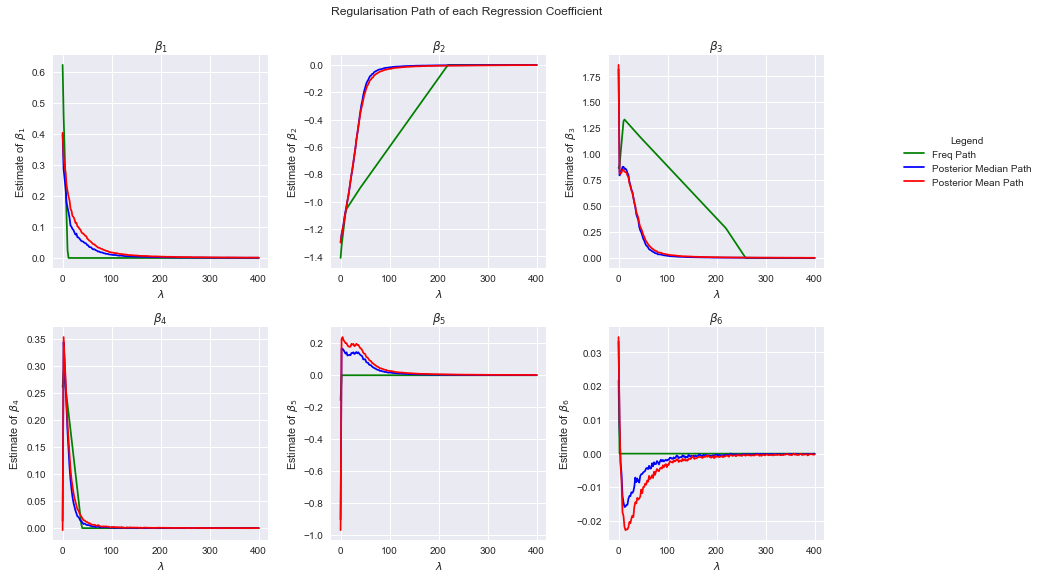

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(15,8))
fig.suptitle("Regularisation Path of each Regression Coefficient",x=0.435,y=1.0)
for row in range(1,3):
    for column in range(1,4):
        ax[row-1][column-1].set_title(fr"$\beta_{{{3*(row-1)+column}}}$")
        ax[row-1][column-1].set_xlabel(r"$\lambda$")
        ax[row-1][column-1].set_ylabel(fr"Estimate of $\beta_{{{3*(row-1)+column}}}$")
        ax[row-1][column-1].plot(lambdas,freqLassoPath[:,3*(row-1)+column-1],color="g",label="Freq Path")
        ax[row-1][column-1].plot(lambdas,lambdaBetaMedians[:,3*(row-1)+column-1],color="b",label="Posterior Median Path")
        ax[row-1][column-1].plot(lambdas,lambdaBetaMeans[:,3*(row-1)+column-1],color="r",label="Posterior Mean Path")
        #if (3*(row-1)+column-1) >=3:
        #    ax[row-1][column-1].set_ylim(-0.1,0.1)
        #if ((row==1) and (column==2)):
        #    ax[row-1][column-1].set_xlim(0,300)
        #else:
        #    ax[row-1][column-1].set_xlim(0,150)
        if ((row==1) and (column==3)):
            ax[row-1][column-1].legend(loc="center right",title="Legend",bbox_to_anchor=(2, 0.5))
        
plt.tight_layout()
plt.show()

# Want to justify why lambda=400 in plots. 
# Wanted to see Beta2 go to zero, simulated dataset suggests strong correlation
# thats why it took longer to go to zero.

In [31]:
# (2) Regularisation paths as a function of relative L1 norm, for posterior median, lasso, ridge, posterior mean
lambdal1BetaMedians = np.linalg.norm(lambdaBetaMedians,1,axis=1)
relativel1BetaMedians = lambdal1BetaMedians/np.max(lambdal1BetaMedians)

lambdal1BetaMeans = np.linalg.norm(lambdaBetaMeans,1,axis=1)
relativel1BetaMeans = lambdal1BetaMeans/np.max(lambdal1BetaMeans)

lambdal1BetaModes = np.linalg.norm(freqLassoPath,1,axis=1)
relativel1BetaModes = lambdal1BetaModes/np.max(lambdal1BetaModes)

In [32]:
# Want to superimpose vertical lines for lambda chosen by MML for posterior summaries, lambda chosen by CV for lasso, ridge

In [35]:
# Find lambda for the frequentist lasso chosen by cross validation

lassoCVmodel = LassoCV(cv=10,fit_intercept=False,max_iter=10000,alphas=np.linspace(0.0005,10,1000))
lassoCVmodel.fit(X_trainStd,np.ravel(y_train-np.mean(y_train)))

l1betaCV = np.linalg.norm(lassoCVmodel.coef_,1)
print("Smallest lambda tested in CV is:",min(lassoCVmodel.alphas_)*2*X_train.shape[0])
print("Largest lambda tested in CV is:",max(lassoCVmodel.alphas_)*2*X_train.shape[0])
print("Number of lambdas tested in CV is:", len(lassoCVmodel.alphas_))
print("Lambda chosen by cross-validation is:", lassoCVmodel.alpha_*2*X_train.shape[0])
print("L1 Norm of the betas with lambda chosen by CV is:", l1betaCV)

Smallest lambda tested in CV is: 0.07
Largest lambda tested in CV is: 1400.0
Number of lambdas tested in CV is: 1000
Lambda chosen by cross-validation is: 9.87931931931932
L1 Norm of the betas with lambda chosen by CV is: 2.6429518030588253


In [36]:
# Calculate Ridge paths
ridgeLambdas = np.linspace(0.1,5000,200)
smRidge = sm.OLS(y_train-np.mean(y_train),X_trainStd)
freqRidgePath = np.zeros((len(ridgeLambdas),6))
for idx in range(len(ridgeLambdas)):
    freqRidgePath[idx,:] = smRidge.fit_regularized(alpha=ridgeLambdas[idx]/(X_train.shape[0]),L1_wt=0).params
    
lambdal1BetaRidge = np.linalg.norm(freqRidgePath,1,axis=1)
relativel1BetaRidge = lambdal1BetaRidge/np.max(lambdal1BetaRidge)

# Find lambda for the frequentist ridge chosen by cross validation

ridgeCVmodel = RidgeCV(cv=10,fit_intercept=False,alphas=lassoCVmodel.alphas_*10)
ridgeCVmodel.fit(X_train,np.ravel(y_train-np.mean(y_train)))

l1betaridgeCV = np.linalg.norm(ridgeCVmodel.coef_,1)

In [37]:
# Find relative l1 norm of beta medians and means for lambdaMML
l1betamedianMML = np.linalg.norm(np.median(burnedbetatracesMML,axis=0),1)
l1betameanMML = np.linalg.norm(np.mean(burnedbetatracesMML,axis=0),1)

relativel1betamedianMML = l1betamedianMML/np.max(lambdal1BetaMedians)
relativel1betameanMML = l1betameanMML/np.max(lambdal1BetaMeans)

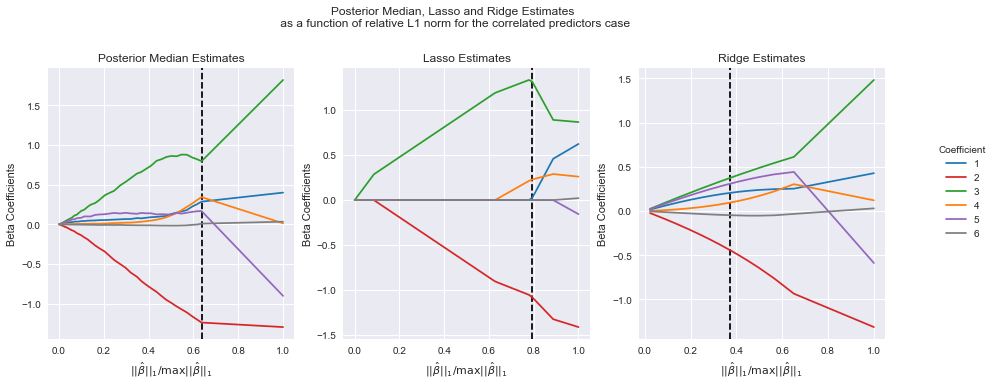

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
colors = ["tab:blue","tab:red","tab:green","tab:orange","tab:purple","tab:gray"]

# First plot Bayesian Lasso median estimates
ax[0].set_xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
ax[0].set_ylabel("Beta Coefficients")
ax[0].set_title("Posterior Median Estimates")
for idx,color in enumerate(colors):
    ax[0].plot(relativel1BetaMedians,lambdaBetaMedians[:,idx],color=color,label=f"{idx+1}")
ax[0].set_ylim()
ax[0].vlines(relativel1betamedianMML,ax[0].get_ylim()[0],ax[0].get_ylim()[1],linestyle="--",colors="0")

# Now plot Lasso estimates
ax[1].set_xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
ax[1].set_ylabel("Beta Coefficients")
ax[1].set_title("Lasso Estimates")

for idx,color in enumerate(colors):
    ax[1].plot(relativel1BetaModes,freqLassoPath[:,idx],color=color,label=f"{idx+1}")
ax[1].set_ylim()
ax[1].vlines(l1betaCV/np.max(lambdal1BetaModes),ax[1].get_ylim()[0],ax[1].get_ylim()[1],linestyle="--",colors="0")

# Now plot Ridge estimates
ax[2].set_xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
ax[2].set_ylabel("Beta Coefficients")
ax[2].set_title("Ridge Estimates")

for idx,color in enumerate(colors):
    ax[2].plot(relativel1BetaRidge,freqRidgePath[:,idx],color=color,label=f"{idx+1}")
    if idx==5:
        handles, labels = ax[2].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right',title="Coefficient")    
ax[2].set_ylim()
ax[2].vlines(l1betaridgeCV/np.max(lambdal1BetaRidge),ax[2].get_ylim()[0],ax[2].get_ylim()[1],linestyle="--",colors="0")
fig.suptitle("Posterior Median, Lasso and Ridge Estimates\n as a function of relative L1 norm for the correlated predictors case",y=1.05)
plt.show()

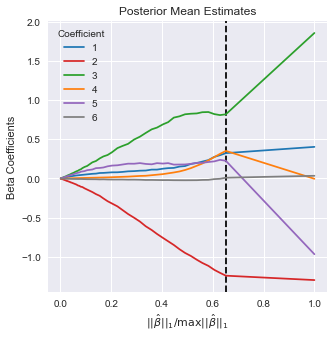

In [39]:
# Lastly do a similar plot for posterior mean

plt.figure(figsize=(5,5))
plt.title("Posterior Mean Estimates")
plt.xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
plt.ylabel("Beta Coefficients")

for idx,color in enumerate(colors):
    plt.plot(relativel1BetaMeans,lambdaBetaMeans[:,idx],color=color,label=f"{idx+1}")

plt.gca().set_ylim()
plt.vlines(relativel1betameanMML,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle="--",colors="0")
plt.legend(title="Coefficient")
plt.show()

# Very similar